In [123]:
# Import packages
import datetime
import geopandas as gpd
import holidays
# import july
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from dbfread import DBF
# import seaborn as sns
import shutil
import time
# Import CEA modules
import cea.config
import cea.api 
from cea.utilities.dbf import *
from cea.utilities.epwreader import epw_reader
from cea.datamanagement.archetypes_mapper import archetypes_mapper
from cea.demand.schedule_maker.schedule_maker import main as schedule_maker
from cea.demand.demand_main import main as demand_main
from cea.resources.radiation.main import main as radiation_main

#Take default dependencies for DAYSIM
# DAYSIM_BIN_DIRECTORY = os.path.join(os.getcwd(), 'CEA_model', '0_daysim_binaries')
project_folder = os.path.join(os.getcwd(), 'CEA_model337')


zone_gdf = gpd.read_file(
    os.path.join(project_folder, 'Baseline', '2020', 'inputs', 'building-geometry', 'zone.shp')) 
list_buildings = zone_gdf["Name"].tolist() 

selection_gdf = zone_gdf.copy()
selection_gdf


,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,postcode,house_name,resi_type,city,country,geometry
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((384874.043 5820594.084, 384873.807 5..."
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,10589,NaN,NaN,Berlin,DE,"POLYGON ((385147.715 5821181.978, 385145.006 5..."
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385315.603 5820595.263, 385265.770 5..."
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385231.453 5820685.213, 385230.993 5..."
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((385092.809 5820650.440, 385096.097 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,B1786,1.0,1,3.0,1,NaN,yes,OSM - as it is,17-20,Tegeler Weg,10589,NaN,NaN,Berlin,DE,"POLYGON ((384583.564 5821007.335, 384573.938 5..."
787,B1787,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((384534.446 5821185.198, 384551.996 5..."
788,B1788,6.0,6,3.0,1,NaN,apartments,OSM - as it is,21,Mierendorffstraße,10589,NaN,NaN,Berlin,DE,"POLYGON ((384788.185 5820672.254, 384786.705 5..."
789,B1789,6.0,6,3.0,1,NaN,apartments,OSM - as it is,23,Mierendorffstraße,10589,NaN,NaN,Berlin,DE,"POLYGON ((384799.372 5820694.503, 384795.628 5..."


In [124]:
# drop everything that is smaller than 40m2  
selection_gdf["area"] = selection_gdf["geometry"].area
buildings_above_40sqm = selection_gdf.query('area> 40')["Name"]

In [125]:
# adjust type on main type for block 
# first check if there is an overlap 
import os 
dir_path = os.getcwd()
shape_data_path = os.path.join(dir_path, 'auxillary',  '00_block_shape.shp')
shapes = gpd.read_file(shape_data_path)
shapes["blknr"] = shapes["blknr"].astype('int64') 
file_path_age = os.path.join(dir_path, 'auxillary','02_Gebäudealter.csv') 
age_df = pd.read_csv(file_path_age)
bldg_age_shapes =  shapes.merge(age_df, on='blknr') 

In [126]:
zone_gdf["geometry"].intersects(bldg_age_shapes["geometry"], align=True)



0      False
1      False
2      False
3      False
4      False
       ...  
786    False
787    False
788    False
789    False
790    False
Length: 791, dtype: bool

In [127]:
list(zone_gdf["category"].value_counts().index)

['yes',
 'apartments',
 'residential',
 'industrial',
 'roof',
 'commercial',
 'allotment_house',
 'office',
 'silo',
 'school',
 'hut',
 'public',
 'retail',
 'service',
 'warehouse',
 'garages',
 'church',
 'construction',
 'garage',
 'house',
 'detached',
 'manufacture',
 'kindergarten',
 'electricity',
 'toilets',
 'sports_hall',
 'houseboat']

# Archetye mapping

Drop houseboat, detached, shed, train_station, toilets, bridge, construction, garage (s), hut, allotment_house, bungalow, church (?), roof, silo, electricity

Assume yes is apparment. 

Compare with: https://wiki.openstreetmap.org/wiki/Key:building 

In [128]:
bldg_to_drop = ["houseboat", "detached", "shed", "train_station", "toilets", "bridge", "construction", "garage", "garages", "hut", "allotment_house",  "roof", "silo", "electricity"]

In [129]:
bldg_type_list = [x for x in list(zone_gdf["category"].value_counts().index) if x not in bldg_to_drop]
bldg_type_list

['yes',
 'apartments',
 'residential',
 'industrial',
 'commercial',
 'office',
 'school',
 'public',
 'retail',
 'service',
 'warehouse',
 'church',
 'house',
 'manufacture',
 'kindergarten',
 'sports_hall']

In [130]:
ARCHETYPES = {
     "apartments": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
    "residential": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
      "yes": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },
    "industrial": {
        "1860-1978": "NWG_G2_A",
        "1979-2009": "NWG_G2_B",
        "2010-2030": "NWG_G2_C",
    }, 

    "office": {
        "1860-1978": "NWG_1_A",
        "1979-2009": "NWG_1_B",
        "2010-2030": "NWG_1_C",
    },
      "commercial": {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "retail" : {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "warehouse": {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
        "service" : {
             "1860-1978": "NWG_10_A",
        "1979-2009": "NWG_10_B",
        "2010-2030": "NWG_10_C",
        },
        "school": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    },
    "public": {
           "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }, 
    "house": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },"manufacture" : {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
    
        "kindergarten": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    }, 
    "sports_hall": {
        "1860-1978": "NWG_6_A",
        "1979-2009": "NWG_6_B",
        "2010-2030": "NWG_6_C",
    }
    , 
    "church": {
        "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }}



In [131]:
print(ARCHETYPES.keys())

dict_keys(['apartments', 'residential', 'yes', 'industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public', 'house', 'manufacture', 'kindergarten', 'sports_hall', 'church'])


In [132]:
gpd.overlay(zone_gdf, bldg_age_shapes, how='intersection')

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015,ew2015,typ,typklar,geometry
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384873.807 5820581.426, 384886.006 5..."
1,B1024,1.0,1,3.0,1,NaN,sports_hall,OSM - as it is,29,Sömmeringstraße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((385043.932 5820642.061, 385043.749 5..."
2,B1026,4.0,4,3.0,1,NaN,public,OSM - as it is,30,Mierendorffstraße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384922.724 5820735.592, 384929.001 5..."
3,B1114,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((385030.143 5820713.906, 385029.951 5..."
4,B1122,3.0,3,3.0,1,NaN,yes,OSM - as it is,22,Nordhauser Straße,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),"POLYGON ((384966.057 5820720.330, 384966.311 5..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,B1779,6.0,6,3.0,1,NaN,residential,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,300.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((385451.043 5820715.937, 385446.869 5..."
1387,B1780,5.0,5,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,323.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384649.990 5821130.060, 384649.766 5..."
1388,B1781,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,691.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384620.571 5821059.758, 384631.713 5..."
1389,B1782,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,691.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,"POLYGON ((384622.619 5821008.006, 384622.870 5..."


In [133]:
def merge_with_max_overlap(gdf_buildings, gdf_blocks):
    # Initialize an empty list to store the result data
    results = []

    # Iterate over each polygon in gdf_buildings
    for index_a, row_a in gdf_buildings.iterrows():
        max_overlap = 0
        best_match = None

        # Compute intersection with each polygon in gdf_blocks and find the max overlap
        for index_b, row_b in gdf_blocks.iterrows():
            intersection = row_a['geometry'].intersection(row_b['geometry'])
            overlap_area = intersection.area

            if overlap_area > max_overlap:
                max_overlap = overlap_area
                best_match = row_b

        # Create a new record for the resulting GeoDataFrame
        if best_match is not None:
            merged_attrs = {**row_a.to_dict(), **best_match.to_dict(), 'overlap_area': max_overlap}
            results.append(merged_attrs)

    # Convert the list of dicts to a GeoDataFrame
    result_gdf = gpd.GeoDataFrame(results, crs=zone_gdf.crs)

    return result_gdf


overlap = merge_with_max_overlap(zone_gdf, bldg_age_shapes)

overlap.head()

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015,ew2015,typ,typklar,overlap_area
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),2526.631853
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,37.0,Kleingartenanlage allgemein,547.822059
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,2139.055172
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,472.988086
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,1.0,5.0,NaN,NaN,NaN,476.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,1151.849618


In [134]:
# Add data for buildings ['B1325', 'B1769'] to the overlap file, then reorder by name 
selected_buildings = zone_gdf[zone_gdf["Name"].isin(['B1325', 'B1769'])]
overlap= gpd.GeoDataFrame(pd.concat([overlap, selected_buildings], ignore_index=True))

overlap = overlap.sort_values(by='Name')


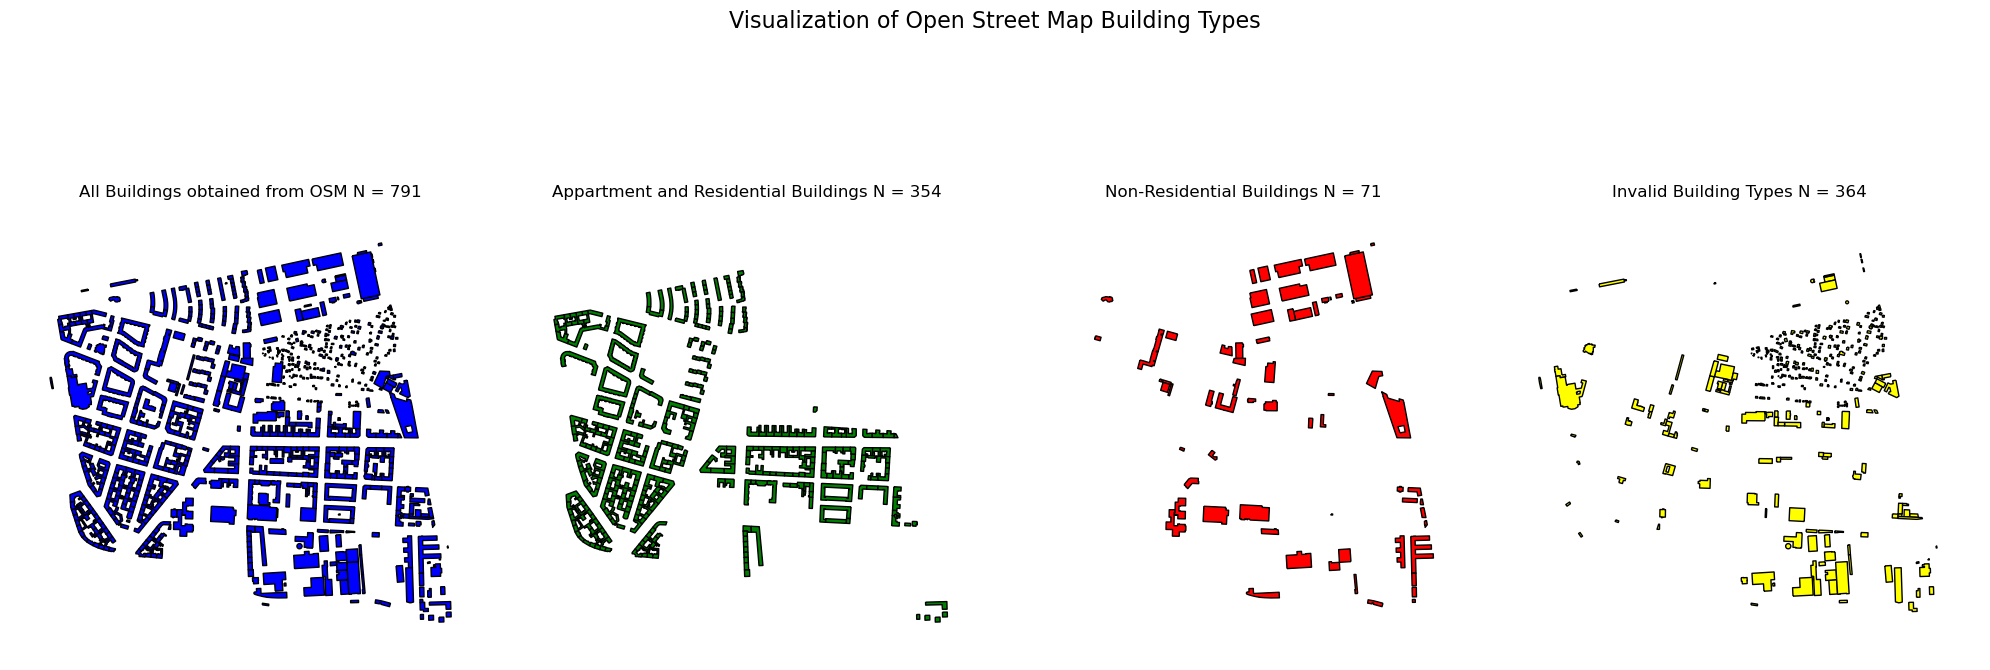

In [135]:
gdf = zone_gdf
# Calculate bounds for consistent axis limits
xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounding box of all geometries

# Extend the bounds a bit for better visualization
xrange = xmax - xmin
yrange = ymax - ymin
xmin -= 0.1 * xrange
xmax += 0.1 * xrange
ymin -= 0.1 * yrange
ymax += 0.1 * yrange

# Plot setup
fig, axs = plt.subplots(1, 4, figsize=(20, 8))  # Horizontal layout with 3 plots

# Plot all geometries
count_all = gdf.shape[0]
gdf.plot(ax=axs[0], color='blue', edgecolor='k')
axs[0].set_title(f'All Buildings obtained from OSM N = {count_all}')
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymin, ymax)

# Plot residential builings
count_type_residential = gdf[gdf['category'].isin(["residential", "apartments", 'house, "bungalow", '])].shape[0]
gdf[gdf['category'].isin(["residential", "apartments", 'house'])].plot(ax=axs[1], color='green', edgecolor='k')
axs[1].set_title(f'Appartment and Residential Buildings N = {count_type_residential}')
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)

# Plot non Residential Buildings
# Count type B entries
count_type_non_residential = gdf[gdf['category'].isin(['industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public',  'manufacture', 'kindergarten', 'sports_hall', "church",])].shape[0]
gdf[gdf['category'].isin(['industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public',  'manufacture', 'kindergarten', 'sports_hall'])].plot(ax=axs[2], color='red', edgecolor='k')
axs[2].set_title(f'Non-Residential Buildings N = {count_type_non_residential}')
axs[2].set_xlim(xmin, xmax)
axs[2].set_ylim(ymin, ymax)

# Plot non valid Building Types
count_type_invalid = gdf[gdf['category'].isin(["houseboat", "yes", "detached", "shed", "train_station", "toilets", "bridge", "construction", "garage", "garages", "hut", "allotment_house", "roof", "silo", "electricity"])].shape[0]
gdf[gdf['category'].isin(["houseboat", "yes", "detached", "shed", "train_station", "toilets", "bridge", "construction", "garage", "garages", "hut", "allotment_house", "bungalow", "church", "roof", "silo", "electricity"])].plot(ax=axs[3], color='yellow', edgecolor='k')
axs[3].set_title(f'Invalid Building Types N = {count_type_invalid}')
axs[3].set_xlim(xmin, xmax)
axs[3].set_ylim(ymin, ymax)

# Remove the axis for a cleaner look and adjust for space between plots
for ax in axs:
    ax.axis('off')

# Common header
plt.suptitle('Visualization of Open Street Map Building Types', fontsize=16)

# Show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the common header
plt.show()

In [136]:
def merge_with_max_overlap(gdf_buildings, gdf_blocks):
    # Initialize an empty list to store the result data
    results = []

    # Iterate over each polygon in gdf_buildings
    for index_a, row_a in gdf_buildings.iterrows():
        max_overlap = 0
        best_match = None
        best_match_attrs = None

        # Compute intersection with each polygon in gdf_blocks and find the max overlap
        for index_b, row_b in gdf_blocks.iterrows():
            intersection = row_a['geometry'].intersection(row_b['geometry'])
            overlap_area = intersection.area

            if overlap_area > max_overlap:
                max_overlap = overlap_area
                best_match = row_b
                # Exclude geometry from row_b to preserve the geometry from row_a
                best_match_attrs = {k: v for k, v in row_b.items() if k != 'geometry'}

        # Create a new record for the resulting GeoDataFrame, preserving row_a's geometry
        if best_match is not None:
            merged_attrs = {**row_a.to_dict(), **best_match_attrs, 'overlap_area': max_overlap}
            results.append(merged_attrs)

    # Convert the list of dicts to a GeoDataFrame
    result_gdf = gpd.GeoDataFrame(results, crs=gdf_buildings.crs)  # Ensure the CRS is taken from gdf_buildings

    return result_gdf

# Example usage:
# Assuming zone_gdf and bldg_age_shapes are your GeoDataFrames loaded beforehand
overlap_reduced = merge_with_max_overlap(zone_gdf, bldg_age_shapes)

# Print the first few rows of the resulting GeoDataFrame
overlap_reduced.head()

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015,ew2015,typ,typklar,overlap_area
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),2526.631853
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,37.0,Kleingartenanlage allgemein,547.822059
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,2139.055172
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,472.988086
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,1.0,5.0,NaN,NaN,NaN,476.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,1151.849618


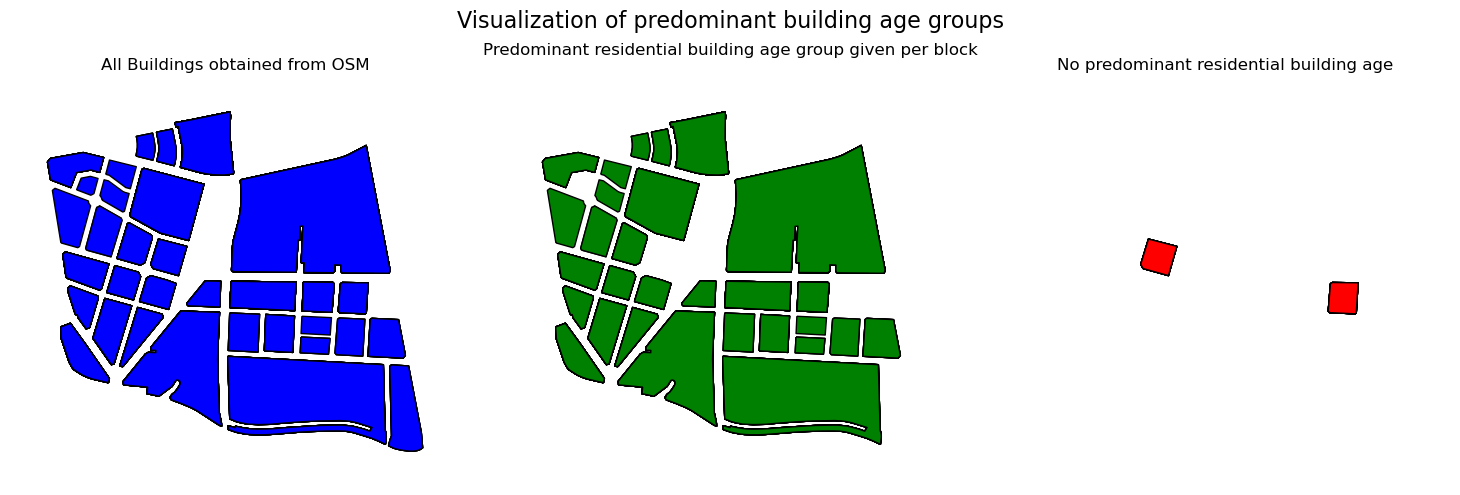

In [137]:

# Ingore yes here, due to diversity of building types
gdf = overlap[overlap['category'].isin(["residential", "apartments", 'house', "bungalow", ])]
# Calculate bounds for consistent axis limits
xmin, ymin, xmax, ymax = gdf.total_bounds  # Get the bounding box of all geometries

# Extend the bounds a bit for better visualization
xrange = xmax - xmin
yrange = ymax - ymin
xmin -= 0.1 * xrange
xmax += 0.1 * xrange
ymin -= 0.1 * yrange
ymax += 0.1 * yrange

# Plot setup
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Horizontal layout with 3 plots

# Plot all geometries
gdf.plot(ax=axs[0], color='blue', edgecolor='k')
axs[0].set_title('All Buildings obtained from OSM')
axs[0].set_xlim(xmin, xmax)
axs[0].set_ylim(ymin, ymax)

# Plot types A and C
gdf[gdf['ueberw_dek'].isin(['2001-2010', '1901-1910', '1951-1960', '2011-2015', 'bis 1900', '1921-1930', '1981-1990', '1931-1940'])].plot(ax=axs[1], color='green', edgecolor='k')
axs[1].set_title('Predominant residential building age group given per block')
axs[1].set_xlim(xmin, xmax)
axs[1].set_ylim(ymin, ymax)

# Plot type B
gdf[gdf['ueberw_dek'].isin(["gemischte Baualtersklasse"])].plot(ax=axs[2], color='red', edgecolor='k')
axs[2].set_title('No predominant residential building age')
axs[2].set_xlim(xmin, xmax)
axs[2].set_ylim(ymin, ymax)

# Remove the axis for a cleaner look and adjust for space between plots
for ax in axs:
    ax.axis('off')

# Common header
plt.suptitle('Visualization of predominant building age groups', fontsize=16)

# Show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the common header
plt.show()

In [138]:
def average_year_from_range(year_range):
    # This function extracts the start and end years from a range, calculates the average, and returns it as an integer
    # "gemischte"
    if '-' in year_range:
        start_year, end_year = year_range.split('-')
        average_year = (int(start_year) + int(end_year)) // 2
        return average_year
    elif "year_range" == "gemischte Baualtersklasse":
        return None 
    elif "year_range" == "bis 1900": 
        return 1900
    elif "year_range" == "NaN":
        return None 

    return int(year_range)  # Handles cases where the year is not a range but a single year


def find_year_range(bldg_type, year):
    # function determines the year range that a given year falls into based on its categorization  
    if bldg_type in ["yes", "apartments", "residential", "house"]:
        #determine bldg age groups on years
        if 1860 <= year <= 1918:
            return "1860-1918"
        elif 1919 <= year <= 1948:
            return "1919-1948"
        elif 1949 <= year <= 1957:
            return "1949-1957"
        elif 1958 <= year <= 1968:
            return "1958-1968"
        elif 1969 <= year <= 1978:
            return "1969-1978"
        elif 1979 <= year <= 2009:
            return None
        else:
            return None 
    else:
        # Non Residential building groups
        if 1860 <= year <= 1978:
            return "1860-1978"
        elif 1979 <= year <= 2009:
            return "1979-2009"
        elif 2010 <= year <= 2030:
            return "2010-2030"
        else:
            return None



def match_building_type( bldg_type, year):
    # This function matches building use to its archetype based on year
    try:
        average_year = average_year_from_range(year)
    except (TypeError, ValueError) as e:
        print(year)
        return None 
    year_range = find_year_range(bldg_type, average_year)
    if bldg_type in ARCHETYPES and year_range in ARCHETYPES[bldg_type]:
        return ARCHETYPES[bldg_type][year_range]
    return None


overlap["ARCHETYPE"] = overlap.apply(lambda row: match_building_type(row['category'], row['ueberw_dek']), axis=1)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
bis 1900
bis

In [139]:
# Create folder for modelling based on suggestions 
archetype = "GER_Updated"
year = "2020"
path_to_new_scenario = os.path.join(project_folder, 'Baseline', f'{year}') # create the destination path for copying the baseline scenario
path_to_baseline = os.path.join(project_folder, 'Baseline', year)
try:
    shutil.copytree(path_to_baseline, path_to_new_scenario)
except WindowsError:
    pass 

In [140]:
# map archetypes based on average year of block and building type 
archetype_path = os.path.join(project_folder, 'Baseline', f'{year}', "inputs", "building-properties", "typology.dbf")
archetype_file = gpd.read_file(archetype_path)
#archetype_file["STANDARD"] = archetype
archetype_file 

,Name,STANDARD,YEAR,1ST_USE,1ST_USE_R,2ND_USE,2ND_USE_R,3RD_USE,3RD_USE_R,REFERENCE,geometry
0,B1000,SFH_C,1934.0,SCHOOL,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1,B1001,SFH_C,1934.0,PARKING,1.0,NONE,0.0,NONE,0.0,OSM - median,None
2,B1002,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
3,B1003,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
4,B1004,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
...,...,...,...,...,...,...,...,...,...,...,...
786,B1786,SFH_C,1934.0,OFFICE,1.0,NONE,0.0,NONE,0.0,OSM - median,None
787,B1787,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
788,B1788,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
789,B1789,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None


In [141]:
# Map the archetypes
archetype_file["STANDARD"] = overlap["ARCHETYPE"]

In [142]:
# Get the list of all builidngs that are modeled
# gdf['category'].isin(["residential", "apartments", 'house, "bungalow", '
'industrial', 'office', 'commercial', 'retail', 'warehouse', 'service', 'school', 'public',  'manufacture', 'kindergarten', 'sports_hall', "church", 
list_buildings = selection_gdf[(~selection_gdf["category"].isin(bldg_to_drop)) & (selection_gdf["area"] > 40)]["Name"].tolist()

In [143]:
# Get all Buildings, where an archetype was assigned
archetype_path = os.path.join(project_folder, 'Baseline', f'{year}', "inputs", "building-properties", "typology.dbf")
typology_dbf = gpd.read_file(archetype_path)

In [144]:
list_assigned_standard = typology_dbf[typology_dbf["STANDARD"].notnull()]["Name"].tolist()

In [145]:
list_assigned_standard

['B1000',
 'B1001',
 'B1002',
 'B1003',
 'B1004',
 'B1005',
 'B1006',
 'B1007',
 'B1008',
 'B1009',
 'B1010',
 'B1011',
 'B1012',
 'B1013',
 'B1014',
 'B1015',
 'B1016',
 'B1017',
 'B1018',
 'B1019',
 'B1020',
 'B1021',
 'B1022',
 'B1023',
 'B1024',
 'B1025',
 'B1026',
 'B1027',
 'B1028',
 'B1029',
 'B1030',
 'B1031',
 'B1032',
 'B1033',
 'B1034',
 'B1035',
 'B1036',
 'B1037',
 'B1038',
 'B1039',
 'B1040',
 'B1041',
 'B1042',
 'B1043',
 'B1044',
 'B1045',
 'B1046',
 'B1047',
 'B1048',
 'B1049',
 'B1050',
 'B1051',
 'B1052',
 'B1053',
 'B1054',
 'B1055',
 'B1056',
 'B1057',
 'B1058',
 'B1059',
 'B1060',
 'B1061',
 'B1062',
 'B1063',
 'B1064',
 'B1065',
 'B1066',
 'B1067',
 'B1068',
 'B1069',
 'B1070',
 'B1071',
 'B1072',
 'B1073',
 'B1074',
 'B1075',
 'B1076',
 'B1077',
 'B1078',
 'B1079',
 'B1080',
 'B1081',
 'B1082',
 'B1083',
 'B1084',
 'B1085',
 'B1086',
 'B1087',
 'B1088',
 'B1089',
 'B1090',
 'B1091',
 'B1092',
 'B1093',
 'B1094',
 'B1095',
 'B1096',
 'B1097',
 'B1098',
 'B1099',


In [49]:
# Create Default Baseline Scenarios for all years 
years = ["2020", "2021", "2022"]
config = cea.config.Configuration()
for year in years: 
    path_to_new_scenario = os.path.join(project_folder, 'Baseline', f'{year}') 
    path_to_baseline = os.path.join(project_folder, 'Baseline', '2020')
    try:
        shutil.copytree(path_to_baseline, path_to_new_scenario)
        config.project = os.path.join(project_folder, 'Baseline')
        config.scenario_name = f'{year}'
    except WindowsError:
        pass 

In [69]:
# Build Baselines for all years
# Just consider the buildings that have been assigned a standard by simply mapping
# Name this default model
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years: 
    #config.data_helper.region = 'DE'
    # create the destination path for copying the baseline scenario
    path_to_new_scenario = os.path.join(project_folder, 'DefaultModel', f'{year}') 
    path_to_baseline = os.path.join(project_folder, 'Baseline', f'{year}')
    try:
        shutil.copytree(path_to_baseline, path_to_new_scenario)
    except WindowsError:
        pass 
    # Set archetypes to previously identifed archetypes
    config.project = os.path.join(project_folder, 'DefaultModel')
    config.scenario_name = f'{year}'

    
    archetype_path = os.path.join(path_to_new_scenario, "inputs", "building-properties", "typology.dbf")
    archetype_file = gpd.read_file(archetype_path)
    archetype_file["STANDARD"] = overlap["ARCHETYPE"]
    no_archetype_buildings = archetype_file[archetype_file["STANDARD"].isnull()]["Name"].tolist()
    archetype_buildings = [x for x in list(archetype_file["Name"]) if x not in no_archetype_buildings]
    archetype_file = archetype_file[archetype_file['Name'].isin(archetype_buildings)]
    archetype_file.to_file(archetype_path)
    zone_path = os.path.join(path_to_new_scenario, "inputs", "building-geometry", "zone.shp")
    zone_gdf = gpd.read_file(zone_path)
    #zone_gdf.drop(zone_gdf[zone_gdf['Name'].isin(no_archetype_buildings)], inplace=True)
    zone_gdf = zone_gdf[zone_gdf['Name'].isin(archetype_buildings)]
    zone_gdf.to_file(zone_path)
    
    archetypes_mapper(locator=cea.inputlocator.InputLocator(config.scenario), 
                      update_architecture_dbf=True, update_air_conditioning_systems_dbf=True, 
                      update_indoor_comfort_dbf=True, update_internal_loads_dbf=True, 
                      update_supply_systems_dbf=True, update_schedule_operation_cea=True, 
                      buildings=archetype_buildings)
    config.schedule_maker.buildings = archetype_buildings 
    schedule_maker(config)
    #config.radiation.buildings = list_assigned_standard
    config.radiation.buildings = archetype_buildings
    radiation_main(config)   
    #config.demand.buildings = list_assigned_standard
    config.demand.overheating_warning = False
    demand_main(config) 

Running occupancy model for scenario c:\Users\felix\Documents\Programmieren\Mierendorff_CEA\CEA_model337\DefaultModel\2020
Running occupancy model  with schedule model=deterministic
Using 11 CPU's
Schedule for building No. 1 completed out of 134: B1000
Schedule for building No. 2 completed out of 134: B1026
Schedule for building No. 3 completed out of 134: B1216
Schedule for building No. 4 completed out of 134: B1228
Schedule for building No. 5 completed out of 134: B1209
Schedule for building No. 6 completed out of 134: B1010
Schedule for building No. 7 completed out of 134: B1080
Schedule for building No. 8 completed out of 134: B1154
Schedule for building No. 9 completed out of 134: B1137
Schedule for building No. 10 completed out of 134: B1199
Schedule for building No. 11 completed out of 134: B1203
Schedule for building No. 12 completed out of 134: B1001
Schedule for building No. 13 completed out of 134: B1210
Schedule for building No. 14 completed out of 134: B1249
Schedule for b

In [146]:
# Now generate a model, where everythin is modeled at as least one building type 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years: 
    
    # create the destination path for copying the baseline scenario
    path_to_new_scenario = os.path.join(project_folder, 'Benchmark', f'{year}') 
    path_to_baseline = os.path.join(project_folder, 'Baseline', f'{year}')
    try:
        shutil.copytree( path_to_baseline, path_to_new_scenario)
        config.project = os.path.join(project_folder, 'Benchmark')
        config.scenario_name = f'{year}'
    except WindowsError:
        pass 

In [147]:
# Model Standard 
# Model Year 
# Model 1st_Use 
shape_gpd = gpd.read_file(os.path.join(project_folder, 'Benchmark', '2020', "inputs", "building-geometry", "zone.shp"))
type_gpd = gpd.read_file(os.path.join(project_folder, 'Benchmark', '2020', "inputs", "building-properties", "typology.dbf"))

<Axes: >

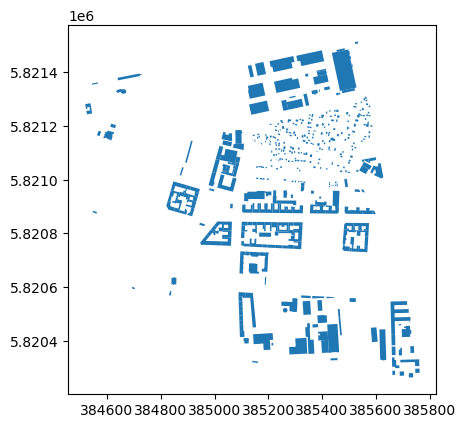

In [148]:
# Visualize building that could not be assigned an archetype
no_archetype = overlap[overlap["ARCHETYPE"].isnull()]["Name"].tolist()
shape_gpd[shape_gpd["Name"].isin(no_archetype)].plot()

In [149]:
# Analzye the building types that could not be assigned an archetype
shape_gpd[shape_gpd["Name"].isin(no_archetype)].category.value_counts()

category
yes                288
apartments          86
roof                12
industrial          11
allotment_house     10
silo                 8
hut                  6
residential          5
commercial           5
garages              4
office               4
warehouse            3
construction         3
retail               3
school               2
garage               2
church               2
kindergarten         1
public               1
toilets              1
service              1
detached             1
manufacture          1
electricity          1
Name: count, dtype: int64

<Axes: >

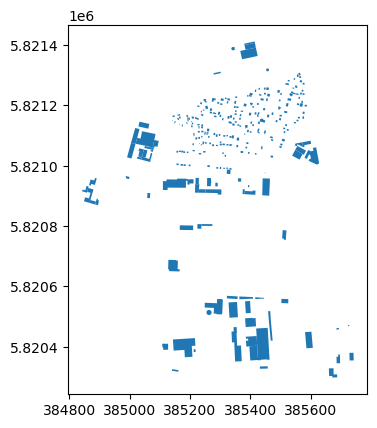

In [150]:
shape_gpd[shape_gpd["Name"].isin(no_archetype) & shape_gpd["category"].isin(["yes"])].plot()


<Axes: >

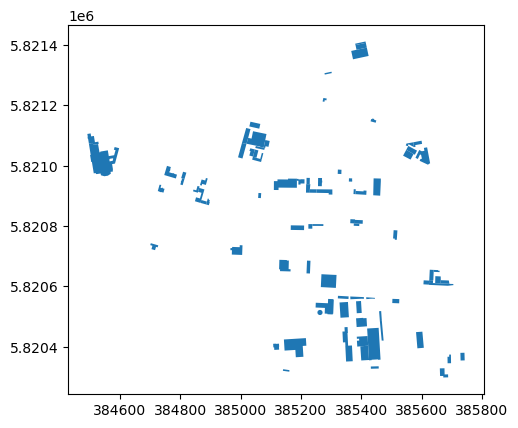

In [151]:
# After visual inspection, yes it it mostly buildings that are related to an type, e.g. the sheds. 
# Get rid of all building smaller than 100m2
shape_gpd["area"] = shape_gpd["geometry"].area
bigger_shape = shape_gpd[shape_gpd["area"] > 100]
bigger_shape[bigger_shape["category"].isin(["yes"])].plot() 

In [152]:
shape_gpd[shape_gpd["area"] > 100 ].category.value_counts()

category
apartments      300
yes              88
residential      51
industrial       16
commercial       10
office            9
school            6
retail            6
public            5
warehouse         4
roof              4
church            3
construction      3
garages           2
service           2
house             2
kindergarten      1
garage            1
electricity       1
manufacture       1
toilets           1
sports_hall       1
houseboat         1
Name: count, dtype: int64

In [153]:
small_buildings = shape_gpd[shape_gpd['area'] < 100]['Name'].tolist()

In [154]:
# Calibration with Archetypes
# For checking different renovation status
# Random Assesment of year for Non Residential Buildings
renovation_arechteypes= ["" , "NR", "AR"] 
non_residential_variations = ["_A", "_B", "_C"]

In [155]:
# For AB type buildings after 1978 no data is available
# Model them as MF 

def find__enhanced_year_range(bldg_type, year):
    # function determines the year range that a given year falls into based on its categorization  
    if bldg_type in ["yes", "apartments", "residential", "house"]:
        #determine bldg age groups on years
        if 1860 <= year <= 1918:
            return "1860-1918"
        elif 1919 <= year <= 1948:
            return "1919-1948"
        elif 1949 <= year <= 1957:
            return "1949-1957"
        elif 1958 <= year <= 1968:
            return "1958-1968"
        elif 1969 <= year <= 1978:
            return "1969-1978"
        elif 1979 <= year <= 1983:
            return "1979-1983"
        elif 1984 <= year <= 1994:
            return "1984-1994"
        elif 1995 <= year <= 2001:
            return "1995-2001"
        elif 2002 <= year <= 2009:
            return "2002-2009"
        elif 2010 <= year <= 2015:
            return "2010-2015"
        elif 2016 <= year <= 2030:
            return "2016-2030"
        else:
            return None
    else:
        # Non Residential building groups
        if 1860 <= year <= 1978:
            return "1860-1978"
        elif 1979 <= year <= 2009:
            return "1979-2009"
        elif 2010 <= year <= 2030:
            return "2010-2030"
        else:
            return None
        
# ADD MFH Archetypes for Apparments constructed after 1978
ENHANCED_ARCHETYPES = {
     "apartments": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        '1979-1983' : "MFH_G",
        "1984-1994" : "MFH_H",
        "1995-2001" : "MFH_I",
        "2002-2009" : "MFH_J",
        "2010-2015" : "MFH_K",
        "2016-2030" : "MFH_L",
    },
    "residential": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        '1979-1983' : "MFH_G",
        "1984-1994" : "MFH_H",
        "1995-2001" : "MFH_I",
        "2002-2009" : "MFH_J",
        "2010-2015" : "MFH_K",
        "2016-2030" : "MFH_L",
    },
      "yes": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
        '1979-1983' : "MFH_G",
        "1984-1994" : "MFH_H",
        "1995-2001" : "MFH_I",
        "2002-2009" : "MFH_J",
        "2010-2015" : "MFH_K",
        "2016-2030" : "MFH_L",
    },
    "industrial": {
        "1860-1978": "NWG_G2_A",
        "1979-2009": "NWG_G2_B",
        "2010-2030": "NWG_G2_C",
    }, 

    "office": {
        "1860-1978": "NWG_1_A",
        "1979-2009": "NWG_1_B",
        "2010-2030": "NWG_1_C",
    },
      "commercial": {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "retail" : {
        "1860-1978": "NWG_G1_A",
        "1979-2009": "NWG_G1_B",
        "2010-2030": "NWG_G1_C",
    }, 
    "warehouse": {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
        "service" : {
            "1860-1978": "NWG_10_A",
        "1979-2009": "NWG_10_B",
        "2010-2030": "NWG_10_C",
        },
        "school": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    },
    "public": {
        "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }, 
    "house": {
        "1860-1918": "AB_B",
        "1919-1948": "AB_C",
        "1949-1957": "AB_D",
        "1958-1968": "AB_E",
        "1969-1978": "AB_F",
    },"manufacture" : {
        "1860-1978": "NWG_8_A",
        "1979-2009": "NWG_8_B",
        "2010-2030": "NWG_8_C",
    }, 
    
        "kindergarten": {
        "1860-1978": "NWG_4_A",
        "1979-2009": "NWG_4_B",
        "2010-2030": "NWG_4_C",
    }, 
    "sports_hall": {
        "1860-1978": "NWG_6_A",
        "1979-2009": "NWG_6_B",
        "2010-2030": "NWG_6_C",
    }
    , 
    "church": {
        "1860-1978": "NWG_5_A",
        "1979-2009": "NWG_5_B",
        "2010-2030": "NWG_5_C",
    }}



In [156]:
def match_enhanced_building_type( bldg_type, year):
    # This function matches building use to its archetype based on year
    try:
        average_year = average_year_from_range(year)
    except (TypeError, ValueError) as e:
        print(year)
        return None 
    year_range = find__enhanced_year_range(bldg_type, average_year)
    if bldg_type in ENHANCED_ARCHETYPES and year_range in ENHANCED_ARCHETYPES[bldg_type]:
        return ENHANCED_ARCHETYPES[bldg_type][year_range]
    return None


overlap["ENHANCED_ARCHETYPE"] = overlap.apply(lambda row: match_enhanced_building_type(row['category'], row['ueberw_dek']), axis=1)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
bis 1900
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
gemischte Baualtersklasse
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
bis 1900
bis

In [157]:
overlap[overlap["ueberw_dek"] == "gemischte Baualtersklasse"][['x_bis_1900', 'x1901_1910', 'x1911_1920', 'x1921_1930', 'x1931_1940', 'x1941_1950', 'x1951_1960', 'x1961_1970', 'x1971_1980', 'x1981_1990', 'x1991_2000', 'x2001_2010', 'x2011_2015']]


,x_bis_1900,x1901_1910,x1911_1920,x1921_1930,x1931_1940,x1941_1950,x1951_1960,x1961_1970,x1971_1980,x1981_1990,x1991_2000,x2001_2010,x2011_2015
41,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
42,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
43,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
44,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
45,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
46,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
47,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
48,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
49,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
50,3.0,4.0,4.0,2.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [158]:
# Model them all as AB_B, as majortiy of buildings is somewhat in this category
overlap.loc[overlap['ueberw_dek'] == 'gemischte Baualtersklasse', 'ENHANCED_ARCHETYPE'] = 'AB_B'


In [159]:
def get_year(year_range):
    # Convert NaN and float to string or handle them separately
    if pd.isna(year_range):
        return None  # Handle NaN values explicitly
    if not isinstance(year_range, str):
        year_range = str(year_range)  # Convert non-string to string

    # Now the original logic, slightly adjusted for clarity
    if '-' in year_range:
        start_year, end_year = year_range.split('-')
        average_year = (int(start_year) + int(end_year)) // 2
        return average_year
    elif year_range == "gemischte Baualtersklasse":  # Fixed the condition checks
        return 1918
    elif year_range == "bis 1900":
        return 1900
    elif year_range == "NaN":  # This check might be redundant now
        return None

    try:
        return int(year_range)  # Handles cases where the year is not a range but a single year
    except ValueError:
        # Handles any unexpected string that cannot be converted directly to int
        return None

overlap["YEAR"] = overlap.apply(lambda row: get_year(row['ueberw_dek']), axis=1)

In [160]:
# Assign 1ST_USE type 
def match_1st_use_building_type( bldg_type, year):
    # This function matches building use to its archetype based on year
    try:
        average_year = average_year_from_range(year)
    except (TypeError, ValueError) as e:
        print(year)
        return None 
    year_range = find__enhanced_year_range(bldg_type, average_year)
    if bldg_type in ENHANCED_ARCHETYPES and year_range in ENHANCED_ARCHETYPES[bldg_type]:
        return ENHANCED_ARCHETYPES[bldg_type][year_range]
    return None

In [161]:
overlap["ARCHETYPE"].value_counts().index
# Assumptions
# For all residential building types, the MULTI_RES is assigned
# For office (NWG1), OFFICE is assigned
# For University (NWG2), UNIVERSITY is assigned
# For IWU Health and care buildings (NWG3), HEALTH is assigned
# For School (NWG4), SCHOOL is assigned
# # For culture, MUSEUM is assigned
# For all industrial buildings, INDUSTRIAL is assigned
# For IWU Technial buildings, TECHNICAL is assigned
USE_DICT = {
    'MFH_J': "MULTI_RES",
    'AB_B': "MULTI_RES",
    'AB_D': "MULTI_RES",
    'MFH_K': "MULTI_RES",
    'AB_C': "MULTI_RES",
    'NWG_5_A': "MUSEUM",
    'NWG_G2_C': "UNIVERSITY",
    'MFH_H': "MULTI_RES",
    'NWG_G1_B': "OFFICE",
    'NWG_G1_C': "OFFICE",
    'NWG_4_A': "SCHOOL",
    'NWG_G1_A': "OFFICE",
    'NWG_G2_A': "INDUSTRIAL",
    'NWG_1_B': "OFFICE",
    'NWG_8_B': "MULTI_RES",
    'NWG_1_A': "MULTI_RES",
    'NWG_10_B': "MULTI_RES",
    'NWG_6_A': "MULTI_RES",
    'NWG_1_C': "OFFICE",
    'NWG_10_A': "INDUSTRIAL",
    'NWG_10_C': "MULTI_RES"
}
overlap["1ST_USE"] = overlap["ENHANCED_ARCHETYPE"].map(USE_DICT)

In [162]:
buildings_assigned_standard = overlap[overlap["1ST_USE"].notnull()]["Name"].tolist()

In [163]:
overlap

,Name,height_ag,floors_ag,height_bg,floors_bg,descriptio,category,REFERENCE,house_no,street,...,x2001_2010,x2011_2015,ew2015,typ,typklar,overlap_area,ARCHETYPE,ENHANCED_ARCHETYPE,YEAR,1ST_USE
0,B1000,2.0,2,3.0,1,NaN,school,OSM - as it is,NaN,NaN,...,NaN,NaN,479.0,13.0,Neubau-Schule (nach 1945),2526.631853,NWG_4_A,NWG_4_A,1905.0,SCHOOL
1,B1001,3.0,3,3.0,1,NaN,service,OSM - as it is,10,Lise-Meitner-Straße,...,2.0,NaN,NaN,37.0,Kleingartenanlage allgemein,547.822059,NWG_10_B,NWG_10_B,2005.0,MULTI_RES
2,B1002,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,2139.055172,AB_D,AB_D,1955.0,MULTI_RES
3,B1003,1.0,1,3.0,1,NaN,yes,OSM - as it is,NaN,NaN,...,NaN,NaN,243.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,472.988086,AB_D,AB_D,1955.0,MULTI_RES
4,B1004,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,476.0,10.0,Blockrandbebauung mit Großhöfen (1920er-1940er...,1151.849618,None,MFH_H,1985.0,MULTI_RES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,B1786,1.0,1,3.0,1,NaN,yes,OSM - as it is,17-20,Tegeler Weg,...,NaN,NaN,214.0,41.0,Sicherheit und Ordnung,6358.958904,AB_C,AB_C,1925.0,MULTI_RES
785,B1787,6.0,6,3.0,1,NaN,apartments,OSM - as it is,NaN,NaN,...,NaN,NaN,744.0,2.0,"Geschlossene Blockbebauung, Hinterhof (1870er-...",1949.023162,AB_C,AB_C,1925.0,MULTI_RES
786,B1788,6.0,6,3.0,1,NaN,apartments,OSM - as it is,21,Mierendorffstraße,...,NaN,NaN,675.0,1.0,"Dichte Blockbebauung, geschlossener Hinterhof ...",764.306084,AB_B,AB_B,1905.0,MULTI_RES
787,B1789,6.0,6,3.0,1,NaN,apartments,OSM - as it is,23,Mierendorffstraße,...,NaN,NaN,675.0,1.0,"Dichte Blockbebauung, geschlossener Hinterhof ...",696.337439,AB_B,AB_B,1905.0,MULTI_RES


In [183]:
# Now generate a model, where everythin is modeled at as least one building type 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years: 
    config.project = os.path.join(project_folder, 'Baseline')
    config.scenario_name = f'{year}'
    # create the destination path for copying the baseline scenario
    path_to_new_scenario = os.path.join(project_folder, 'Benchmark', f'{year}') 
    path_to_baseline = os.path.join(project_folder, 'Baseline', f'{year}')
    try:
        shutil.copytree(path_to_baseline, path_to_new_scenario)
    except WindowsError:
        pass 

In [172]:
# Create a dictionary from overlap for fast lookup
overlap_new_index = overlap.copy()
overlap_dict = overlap_new_index.set_index('Name').to_dict(orient='index')
# Custom function to update the STANDARD column
def update_standard(row):
    if row['Name'] in overlap_dict:
        arch = overlap_dict[row['Name']]['ARCHETYPE']
        enh_arch = overlap_dict[row['Name']]['ENHANCED_ARCHETYPE']
        return arch if pd.notna(arch) else enh_arch
    return row['STANDARD']

ValueError: DataFrame index must be unique for orient='index'.

In [192]:
overlap_copy = overlap.copy()

# Ensure no duplicate 'Name' values in overlap
overlap_copy = overlap_copy.drop_duplicates(subset='Name')

# Create a dictionary from overlap for fast lookup
overlap_dict = overlap_copy.set_index('Name').to_dict(orient='index')


# Custom function to update the STANDARD, 1ST_USE and YEAR columns
def update_columns(row):
    if row['Name'] in overlap_dict:
        arch = overlap_dict[row['Name']]['ARCHETYPE']
        enh_arch = overlap_dict[row['Name']]['ENHANCED_ARCHETYPE']
        first_use = overlap_dict[row['Name']]['1ST_USE']
        year = overlap_dict[row['Name']]['YEAR']
        
        standard = arch if pd.notna(arch) else enh_arch
        return pd.Series([standard, first_use])
    return pd.Series([row['STANDARD'], row['1ST_USE'], row["YEAR"]])


In [177]:
# Reset Index of overlap for mapping 
overlap["ARCHETYPE"] = np.where(overlap["ARCHETYPE"].isnull(), overlap["ENHANCED_ARCHETYPE"], overlap["ARCHETYPE"])
archetype_map = overlap.set_index('Name')['ARCHETYPE']
year_map = overlap.set_index('Name')['YEAR']
first_use_map = overlap.set_index('Name')['1ST_USE']

In [193]:
# Now generate a model, where everythin is modeled at as least one building type 
import cea.config
config = cea.config.Configuration()
config.multiprocessing = True
years = ["2020", "2021", "2022"]

for year in years: 

    config.project = os.path.join(project_folder, 'Benchmark')
    config.scenario_name = f'{year}'
    path_to_new_scenario = os.path.join(project_folder, 'Benchmark', f'{year}')

    
    archetype_path = os.path.join(path_to_new_scenario, "inputs", "building-properties", "typology.dbf")
    archetype_file = gpd.read_file(archetype_path)

    archetype_file [['STANDARD', '1ST_USE', "YEAR"]] = archetype_file.apply(update_columns, axis=1)

    no_archetype_buildings = archetype_file[archetype_file["STANDARD"].isnull()]["Name"].tolist() + archetype_file[archetype_file["1ST_USE"].isnull()]["Name"].tolist()


    archetype_buildings = [x for x in list(archetype_file["Name"]) if x not in no_archetype_buildings]
    archetype_file = archetype_file[archetype_file['Name'].isin(archetype_buildings)]
    archetype_file.to_file(archetype_path)
    zone_path = os.path.join(path_to_new_scenario, "inputs", "building-geometry", "zone.shp")
    zone_gdf = gpd.read_file(zone_path)
    #zone_gdf.drop(zone_gdf[zone_gdf['Name'].isin(no_archetype_buildings)], inplace=True)
    zone_gdf = zone_gdf[zone_gdf['Name'].isin(archetype_buildings)]
    zone_gdf.to_file(zone_path)
    
    archetypes_mapper(locator=cea.inputlocator.InputLocator(config.scenario), 
                      update_architecture_dbf=True, update_air_conditioning_systems_dbf=True, 
                      update_indoor_comfort_dbf=True, update_internal_loads_dbf=True, 
                      update_supply_systems_dbf=True, update_schedule_operation_cea=True, 
                      buildings=archetype_buildings)
    config.schedule_maker.buildings = archetype_buildings 
    schedule_maker(config)
    #config.radiation.buildings = list_assigned_standard
    config.radiation.buildings = archetype_buildings
    radiation_main(config)   
    #config.demand.buildings = list_assigned_standard
    config.demand.overheating_warning = False
    demand_main(config) 



Running occupancy model for scenario c:\Users\felix\Documents\Programmieren\Mierendorff_CEA\CEA_model337\Benchmark\2020
Running occupancy model  with schedule model=deterministic
Using 11 CPU's
Schedule for building No. 1 completed out of 640: B1126
Schedule for building No. 2 completed out of 640: B1156
Schedule for building No. 3 completed out of 640: B1000
Schedule for building No. 4 completed out of 640: B1171
Schedule for building No. 5 completed out of 640: B1103
Schedule for building No. 6 completed out of 640: B1059
Schedule for building No. 7 completed out of 640: B1186
Schedule for building No. 8 completed out of 640: B1019
Schedule for building No. 9 completed out of 640: B1141
Schedule for building No. 10 completed out of 640: B1044
Schedule for building No. 11 completed out of 640: B1088
Schedule for building No. 12 completed out of 640: B1157
Schedule for building No. 13 completed out of 640: B1001
Schedule for building No. 14 completed out of 640: B1142
Schedule for buil

In [185]:
archetype_file

,Name,STANDARD,YEAR,1ST_USE,1ST_USE_R,2ND_USE,2ND_USE_R,3RD_USE,3RD_USE_R,REFERENCE,geometry
0,B1000,SFH_C,1934.0,SCHOOL,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1,B1001,SFH_C,1934.0,PARKING,1.0,NONE,0.0,NONE,0.0,OSM - median,None
2,B1002,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
3,B1003,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
4,B1004,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
...,...,...,...,...,...,...,...,...,...,...,...
786,B1786,SFH_C,1934.0,OFFICE,1.0,NONE,0.0,NONE,0.0,OSM - median,None
787,B1787,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
788,B1788,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
789,B1789,SFH_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None


In [186]:
archetype_map

Name
B1000     NWG_4_A
B1001    NWG_10_B
B1002        AB_D
B1003        AB_D
B1004       MFH_H
           ...   
B1786        AB_C
B1787        AB_C
B1788        AB_B
B1789        AB_B
B1790     NWG_5_A
Name: ARCHETYPE, Length: 791, dtype: object

In [189]:
overlap_copy = overlap.copy()

# Ensure no duplicate 'Name' values in overlap
overlap_copy = overlap_copy.drop_duplicates(subset='Name')

# Create a dictionary from overlap for fast lookup
overlap_dict = overlap_copy.set_index('Name').to_dict(orient='index')

# Custom function to update the STANDARD column
def update_standard(row):
    if row['Name'] in overlap_dict:
        arch = overlap_dict[row['Name']]['ARCHETYPE']
        enh_arch = overlap_dict[row['Name']]['ENHANCED_ARCHETYPE']
        return arch if pd.notna(arch) else enh_arch
    return row['STANDARD']

# Apply the custom function
archetype_file['STANDARD'] = archetype_file.apply(update_standard, axis=1)

In [190]:
archetype_file

,Name,STANDARD,YEAR,1ST_USE,1ST_USE_R,2ND_USE,2ND_USE_R,3RD_USE,3RD_USE_R,REFERENCE,geometry
0,B1000,NWG_4_A,1934.0,SCHOOL,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1,B1001,NWG_10_B,1934.0,PARKING,1.0,NONE,0.0,NONE,0.0,OSM - median,None
2,B1002,AB_D,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
3,B1003,AB_D,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
4,B1004,MFH_H,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
...,...,...,...,...,...,...,...,...,...,...,...
786,B1786,AB_C,1934.0,OFFICE,1.0,NONE,0.0,NONE,0.0,OSM - median,None
787,B1787,AB_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
788,B1788,AB_B,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
789,B1789,AB_B,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None


<bound method Series.drop_duplicates of Name
B1000     NWG_4_A
B1001    NWG_10_B
B1002        AB_D
B1003        AB_D
B1004       MFH_H
           ...   
B1786        AB_C
B1787        AB_C
B1788        AB_B
B1789        AB_B
B1790     NWG_5_A
Name: ARCHETYPE, Length: 791, dtype: object>

In [ ]:
# Merge archetype_file with overlap on the "Name" column
merged_df = pd.merge(archetype_file, overlap[['Name', 'ARCHETYPE', 'ENHANCED_ARCHETYPE', '1ST_USE', 'YEAR']], on='Name', how='left')

# Update the "STANDARD" column based on whether "ARCHETYPE" is NaN
merged_df["STANDARD"] = np.where(pd.isna(merged_df["ARCHETYPE"]), merged_df["ENHANCED_ARCHETYPE"], merged_df["ARCHETYPE"])


In [ ]:
merged_df

,Name,STANDARD,YEAR_x,1ST_USE_x,1ST_USE_R,2ND_USE,2ND_USE_R,3RD_USE,3RD_USE_R,REFERENCE,geometry,ARCHETYPE,ENHANCED_ARCHETYPE,1ST_USE_y,YEAR_y
0,B1000,NWG_4_A,1934.0,SCHOOL,1.0,NONE,0.0,NONE,0.0,OSM - median,None,NWG_4_A,NWG_4_A,SCHOOL,1905.0
1,B1001,NWG_10_B,1934.0,PARKING,1.0,NONE,0.0,NONE,0.0,OSM - median,None,NWG_10_B,NWG_10_B,MULTI_RES,2005.0
2,B1002,AB_D,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None,AB_D,AB_D,MULTI_RES,1955.0
3,B1003,AB_D,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None,AB_D,AB_D,MULTI_RES,1955.0
4,B1004,MFH_H,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None,None,MFH_H,MULTI_RES,1985.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,B1786,AB_C,1934.0,OFFICE,1.0,NONE,0.0,NONE,0.0,OSM - median,None,AB_C,AB_C,MULTI_RES,1925.0
789,B1787,AB_C,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None,AB_C,AB_C,MULTI_RES,1925.0
790,B1788,AB_B,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None,AB_B,AB_B,MULTI_RES,1905.0
791,B1789,AB_B,1934.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None,AB_B,AB_B,MULTI_RES,1905.0


In [ ]:
archetype_file


In [ ]:
archetype_file

,Name,STANDARD,YEAR,1ST_USE,1ST_USE_R,2ND_USE,2ND_USE_R,3RD_USE,3RD_USE_R,REFERENCE,geometry
0,B1000,NWG_4_A,1905.0,SCHOOL,1.0,NONE,0.0,NONE,0.0,OSM - median,None
1,B1001,NWG_10_B,2005.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
2,B1002,AB_D,1955.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
3,B1003,AB_D,1955.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
4,B1004,MFH_H,1985.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
...,...,...,...,...,...,...,...,...,...,...,...
786,B1786,AB_C,1905.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
787,B1787,AB_C,1905.0,MULTI_RES,1.0,NONE,0.0,NONE,0.0,OSM - median,None
788,B1788,AB_B,1905.0,MUSEUM,1.0,NONE,0.0,NONE,0.0,OSM - median,None
789,B1789,AB_B,NaN,NaN,1.0,NONE,0.0,NONE,0.0,OSM - median,None


In [ ]:
overlap

In [ ]:
[x for x in list(archetype_file["Name"]) if x not in list(overlap["Name"])]

In [ ]:
config.scenario